# Data cleaning on movie dataset

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Vizualizing data helps to illustrate certain attributes of the dataset and display meaningful analytics

In [70]:
data_file = '../data/movieDB.csv'
movies_df = pd.read_csv(data_file)
movies_df.describe()

,year
count,8867.000000
mean,2008.800383
std,14.756871
min,1921.000000
25%,2008.000000
50%,2014.000000
75%,2017.000000
max,2020.000000


In [71]:
movies_df.head()

,url,title,original_title,year,country,genre,plot
0,https://www.filmy.gr/movies-database/assault-o...,'Επίθεση στο Σταθμό 13','Assault on Precinct 13',2005,ΗΠΑ,"Αστυνομική,Δράσης,Θρίλερ",Αυτή η παραμονή Πρωτοχρονιάς θα είναι διαφορετ...
1,https://www.filmy.gr/movies-database/ali-2001/,'Ali','Ali',2001,ΗΠΑ,"Αθλητική,Βιογραφία,Δραματική,Εποχής,Ιστορική,Π...","Ανάμεσα στη δεκαετία 1964-1974, το άστρο του έ..."
2,https://www.filmy.gr/movies-database/pina/,'Πίνα Μπάους','Pina',2011,Γερμανία,"Μουσική,Ντοκιμαντέρ,Σινεφίλ,Χορευτική",Ο Βιμ Βέντερς παρουσιάζει μια ταινία για τη ζω...
3,https://www.filmy.gr/movies-database/batman-be...,'Batman Begins','Batman Begins',2005,ΗΠΑ,"Δράσης,Επιστημονικής Φαντασίας,Έπος,Θρίλερ,Περ...","Ο Μπρους Γουέιν, σε μικρή ηλικία, βλέπει τη δο..."
4,https://www.filmy.gr/movies-database/chitty-ch...,"'Τσίτι-Τσίτι, Μπανγκ-Μπανγκ'",'Chitty Chitty Bang Bang',1968,Μ. Βρετανία,"Εποχής,Κωμωδία,Μιούζικαλ,Οικογενειακή,Περιπέτε...",Ήταν ένα παλιό σαραβαλάκι. Ποιος θα το φανταζό...


Data needs to be processed since there are duplicate records. Also the genre information needs to be more comprehensive.
Removing duplicates:

In [72]:
movies_df.drop_duplicates(inplace=True)
movies_df.describe()

,year
count,3756.000000
mean,2009.332535
std,14.512933
min,1921.000000
25%,2010.000000
50%,2015.000000
75%,2017.000000
max,2020.000000


Some movie genres happen to contain the county information, for movies where multiple countries were involved. The following code identifies such instances and appends the first element of genre, which happens to be the miss-classified country, to the country column. Afterwards the first element of genre is ommited.

In [73]:
missclassified_genres = [genres for genres in movies_df['genre'].values if genres.split(',')[0] in movies_df['country'].values]
print(missclassified_genres[:5])
# cleaning
while missclassified_genres:
    movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'country'] += ',' + movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'genre'].apply(lambda x: x.split(',')[0])
    movies_df.loc[movies_df['genre'].isin(missclassified_genres), 'genre'] = movies_df[movies_df['genre'].isin(missclassified_genres)]['genre'].apply(lambda x: ','.join(x.split(',')[1:]))
    missclassified_genres = [genres for genres in movies_df['genre'].values if genres.split(',')[0] in movies_df['country'].values]

missclassified_genres

[]


[]

Each movie can be classified to multiple genres most of the times. We will attemp to vizualize the distribution of the genres across the datase.

In [74]:
# Get unique genre list
genre_list = list(set([genre  for genres in movies_df['genre'].values for genre in genres.strip().split(',')]))

for genre in genre_list:
    movies_df[genre] = movies_df['genre'].apply(lambda x: 1 if genre in x.split(',') else 0) 

vizualization_df = movies_df[genre_list]
vizualization_df.head()

,Οικογενειακή,Ερωτική,Μουσική,Παρωδία,Πολιτική,Θρησκευτική,Κινούμενα Σχέδια,Μεταφυσικό Θρίλερ,Σάτιρα,Βιογραφία,...,Αστυνομική,Χορευτική,Επιστημονικής Φαντασίας,Πολεμικό Δράμα,Εποχής,Σινεφίλ,Γουέστερν,Ντοκιμαντέρ,Tηλεταινία,Μαύρη Κωμωδία
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


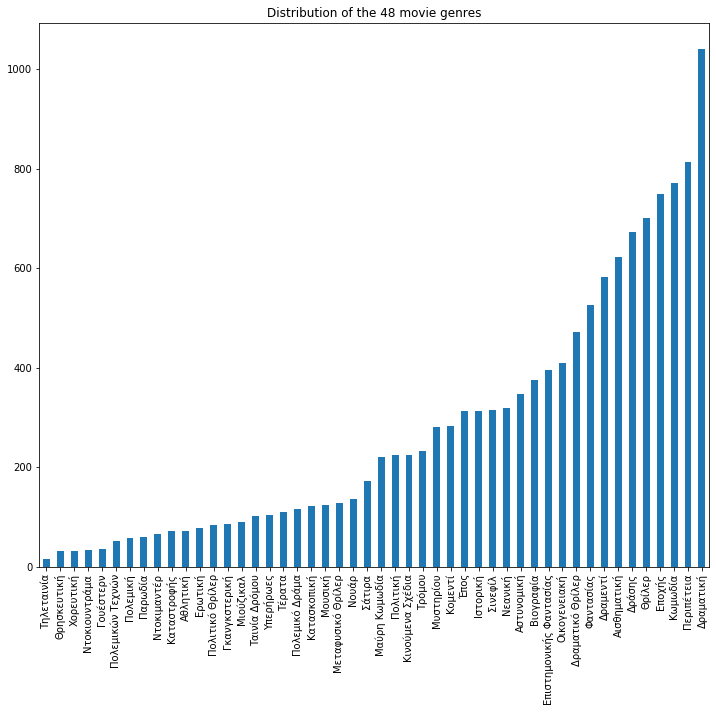

In [75]:
vizualization_df.sum().sort_values().plot(kind='bar',
                                          figsize=(12,10),
                                          stacked=True, 
                                          title='Distribution of the %d movie genres' % len(genre_list))

It seems that the representation of many less common genres is quite sparse in our dataset. Consequently, we will restrict the possible space of predictable genres by calculating the more prevalent movie genres. In fact we can observe that the movie genre distribution follows a power law distribution [[1]](https://en.wikipedia.org/wiki/Power_law#Scale_invariance). Thus we will investigate the effect of the Pareto Principle [[2]](https://en.wikipedia.org/wiki/Pareto_principle) and keep the top 30% of the most represented genres. 

First we drop the less represented genres and create a list of movies that end up not belonging to any genre, if the number of movies in this list is insignificant we could drop the movies as well. 
Otherwise, we will attempt to infer the genre the best discribes the movie from the list of the most popular genres. This can be done by:

1. exploring the genre correlation
2. calculating the gengre frequency co-occurance in movies that are classified to multiple genres
3. determine the unpopular genre predictability by calculating the genre import through random forests classification


List of the top 30% most represented genres in the dataset:

In [76]:
popularity_df = vizualization_df[genre_list].sum().sort_values(ascending=False)[:int(vizualization_df.shape[1]*.25)]
popular_genre_list = popularity_df.index
unpopular_genre_list = [genre for genre in genre_list if genre not in popular_genre_list]
unpopular_genre_list

['Ερωτική',
 'Μουσική',
 'Παρωδία',
 'Πολιτική',
 'Θρησκευτική',
 'Κινούμενα Σχέδια',
 'Μεταφυσικό Θρίλερ',
 'Σάτιρα',
 'Βιογραφία',
 'Νουάρ',
 'Πολεμική',
 'Πολεμικών Τεχνών',
 'Τέρατα',
 'Κομεντί',
 'Μιούζικαλ',
 'Μυστηρίου',
 'Τρόμου',
 'Νεανική',
 'Αθλητική',
 'Γκανγκστερική',
 'Ντοκιουντράμα',
 'Κατασκοπική',
 'Πολιτικό Θρίλερ',
 'Έπος',
 'Καταστροφής',
 'Ταινία Δρόμου',
 'Ιστορική',
 'Υπερήρωες',
 'Αστυνομική',
 'Χορευτική',
 'Πολεμικό Δράμα',
 'Σινεφίλ',
 'Γουέστερν',
 'Ντοκιμαντέρ',
 'Tηλεταινία',
 'Μαύρη Κωμωδία']

#### Dropping the less popular genres:

In [77]:
genre_popularity_df = movies_df[genre_list].copy()
genre_popularity_df.drop(labels=unpopular_genre_list, axis=1, inplace=True)
genre_popularity_df

,Οικογενειακή,Δραμεντί,Περιπέτεια,Κωμωδία,Δράσης,Αισθηματική,Δραματική,Θρίλερ,Δραματικό Θρίλερ,Φαντασίας,Επιστημονικής Φαντασίας,Εποχής
0,0,0,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,1,0,0,1,0
4,1,0,1,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8855,0,0,0,0,0,0,1,0,0,0,0,1
8856,0,0,0,0,0,1,1,0,0,0,0,1
8858,0,0,0,0,0,0,1,0,0,0,0,0
8859,0,0,0,0,0,0,1,0,0,0,0,0


Movies not belonging to a genre:

In [78]:
uncategorized_movies_df = movies_df[genre_popularity_df.sum(axis=1)==0]
uncategorized_movies_df.shape

(74, 55)

Eventually only **74 movies remain unassigned** after dropping the unpopular genres. The number of unassigned movies is not detrimental to the sizing of our dataset, thus they can be dropped as well.

In [79]:
movies_df.drop(labels=unpopular_genre_list, axis=1, inplace=True)
movies_df.drop(labels=uncategorized_movies_df.index, axis=0, inplace=True)
movies_df.describe()

,year,Οικογενειακή,Δραμεντί,Περιπέτεια,Κωμωδία,Δράσης,Αισθηματική,Δραματική,Θρίλερ,Δραματικό Θρίλερ,Φαντασίας,Επιστημονικής Φαντασίας,Εποχής
count,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000,3682.000000
mean,2009.307442,0.111353,0.158338,0.221076,0.209125,0.182781,0.168930,0.282455,0.190114,0.128191,0.142586,0.107279,0.203422
std,14.365660,0.314611,0.365107,0.415028,0.406739,0.386539,0.374741,0.450255,0.392444,0.334348,0.349697,0.309509,0.402598
min,1921.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Distribution of the remaining genres and movie count:

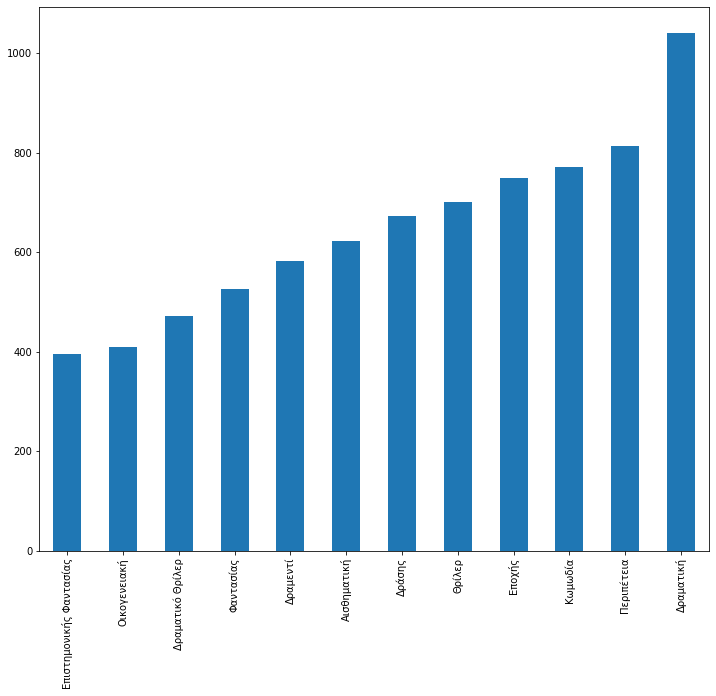

In [80]:
movies_df[popular_genre_list].sum().sort_values().plot(kind='bar', figsize=(12,10),stacked=True)

Exporting cleaned data

In [81]:
movies_df.reset_index(drop=True, inplace=True)
movies_df.to_csv('../data/movieDB_clean.csv')

# TODO

### 1. Parse movies where plot was not captured

In [82]:
movies_df[movies_df['plot'].isnull()]

,url,title,original_title,year,country,genre,plot,Οικογενειακή,Δραμεντί,Περιπέτεια,Κωμωδία,Δράσης,Αισθηματική,Δραματική,Θρίλερ,Δραματικό Θρίλερ,Φαντασίας,Επιστημονικής Φαντασίας,Εποχής


### 2. Parse movies where plot parsed incοrrectly

In [83]:
movies_df[movies_df['plot'].apply(lambda x: str(x).startswith(':'))]

,url,title,original_title,year,country,genre,plot,Οικογενειακή,Δραμεντί,Περιπέτεια,Κωμωδία,Δράσης,Αισθηματική,Δραματική,Θρίλερ,Δραματικό Θρίλερ,Φαντασίας,Επιστημονικής Φαντασίας,Εποχής
